In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
from torch.autograd import Function

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import mnistm

In [2]:
img_size = 32
batch_size = 1000
learning_rate = 0.001
epoch = 50

# load datasets (MNIST, MNIST_M)
trans = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
trans2 = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_dataloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=True, download=True, transform=trans),
                                              batch_size = batch_size, shuffle=True)
mnistm_dataloader = torch.utils.data.DataLoader(mnistm.MNISTM('./data/MNIST_M/', train=True, download=True, transform=trans2),
                                                batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnistm.MNISTM('./data/MNIST_M/', train=False, download=True, transform=trans2),
                                                batch_size = 5000, shuffle=False)

In [3]:
class GradRev(Function):
    def __init__(self, lbda):
        self.lbda = lbda
        
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad):
        return -grad * self.lbda

def grad_reverse(x, alpha):
    return GradRev(alpha)(x)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #feature extractor
        self.feature_extractor = nn.Sequential()
        
        self.feature_extractor.add_module('fe_conv1', nn.Conv2d(3, 12, 5)) #input 3*32*32, output 12*28*28
        self.feature_extractor.add_module('fe_bn1', nn.BatchNorm2d(12)) 
        self.feature_extractor.add_module('fe_pool1', nn.MaxPool2d(2, 2)) #input 12*28*28 output 12*14*14
        self.feature_extractor.add_module('fe_relu1', nn.ReLU(True))
        self.feature_extractor.add_module('fe_dp1', nn.Dropout())
        
        self.feature_extractor.add_module('fe_conv2', nn.Conv2d(12, 24, 5)) #input 12*14*14 output 24*10*10
        self.feature_extractor.add_module('fe_bn2', nn.BatchNorm2d(24))
        self.feature_extractor.add_module('fe_pool2', nn.MaxPool2d(2, 2)) #input 24*10*10 output 24*5*5
        self.feature_extractor.add_module('fe_relu2', nn.ReLU(True))
        self.feature_extractor.add_module('fe_dp2', nn.Dropout())
        
        #label predictor
        self.label_predictor = nn.Sequential()
        
        self.label_predictor.add_module('lp_fc1', nn.Linear(24*5*5, 300))
        self.label_predictor.add_module('lp_bn1', nn.BatchNorm1d(300))
        self.label_predictor.add_module('lp_relu1', nn.ReLU(True))
        self.label_predictor.add_module('lp_dp1', nn.Dropout())
        
        self.label_predictor.add_module('lp_fc2', nn.Linear(300, 100))
        self.label_predictor.add_module('lp_bn2', nn.BatchNorm1d(100))
        self.label_predictor.add_module('lp_relu2', nn.ReLU(True))
        self.label_predictor.add_module('lp_dp2', nn.Dropout())
        
        self.label_predictor.add_module('lp_fc3', nn.Linear(100, 10))
        self.label_predictor.add_module('lp_softmax', nn.LogSoftmax())
        
        #domain classifier
        self.domain_classifier = nn.Sequential()
        
        self.domain_classifier.add_module('dc_fc1', nn.Linear(24*5*5, 300))
        self.domain_classifier.add_module('dc_bn1', nn.BatchNorm1d(300))
        self.domain_classifier.add_module('dc_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('dc_dp1', nn.Dropout())
        
        self.domain_classifier.add_module('dc_fc2', nn.Linear(300,100))
        self.domain_classifier.add_module('dc_bn2', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('dc_relu2', nn.ReLU(True))
        self.domain_classifier.add_module('dc_dp2', nn.Dropout())
        
        self.domain_classifier.add_module('dc_fc3', nn.Linear(100, 2))
        self.domain_classifier.add_module('dc_softmax', nn.LogSoftmax(dim=1))
        
    def forward(self, data, lbda):
        data = data.expand(data.shape[0], 3, img_size, img_size)
        feature = self.feature_extractor(data).view(-1, 24 * 5 * 5)
        rev = grad_reverse(feature, lbda)
        label = self.label_predictor(feature)
        domain = self.domain_classifier(rev)
        
        return label, domain

In [7]:
model = Model().cuda()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_y = torch.nn.NLLLoss().cuda() #class loss
loss_d = torch.nn.NLLLoss().cuda() #domain loss

steps = []
class_loss = []
domain_loss = []
val_acc = []

max_acc = 0.0

for param in model.parameters():
    param.requires_grad = True

j = 0
for n in range(epoch):
    source_iter = iter(mnist_dataloader)
    target_iter = iter(mnistm_dataloader)
    
    length = int(len(mnist_dataloader))
    for i in range(length):
        j += 1
        model.zero_grad()
        
        lbda = 0.61
        source_img, source_label = source_iter.next()
        domain_label = torch.zeros(len(source_label))

        source_img = source_img.cuda()
        source_label = source_label.cuda()
        domain_label = domain_label.long().cuda()
        
        label, domain = model.forward(source_img, lbda)
        l1 = loss_y(label, source_label)
        l2 = loss_d(domain, domain_label)
        
        target_img, target_label = target_iter.next()
        domain_label = torch.ones(len(target_label))
        
        target_img = target_img.cuda()
        domain_label = domain_label.long().cuda()
        
        label, domain = model.forward(target_img, lbda)
        l3 = loss_d(domain, domain_label)
        
        loss = l1 + l2 + l3
        loss.backward()
        
        optimizer.step()
        
        if j % 10 == 0:
            torch.save(model, 'model.pth')
            eval_model = torch.load('model.pth').eval().cuda()
    
            test_iter = iter(test_dataloader)
            val_img, val_label = test_iter.next()
            val_img = val_img.cuda()
            val_label = val_label.cuda()
            domain_label = torch.ones(len(val_label)).long().cuda()
    
            label, domain = eval_model.forward(val_img, lbda)
            l1 = loss_y(label, val_label).cpu().detach().numpy()[()]
            l2 = loss_d(domain, domain_label).cpu().detach().numpy()[()]
            acc = np.mean((np.argmax(label.cpu().detach().numpy(), axis=1) == val_label.cpu().detach().numpy()).astype(int))
    
            if acc > max_acc:
                torch.save(eval_model, 'best_model.pth')
                max_acc = acc
            del eval_model
            steps.append(j)
            class_loss.append(float(l1))
            domain_loss.append(float(l2))
            val_acc.append(float(acc))
    
            print(j, l1, l2, acc)

10 2.283851 0.71775883 0.1182
20 2.242135 0.70012814 0.212
30 2.2585375 0.6951122 0.2504
40 2.222746 0.67368674 0.2938
50 2.1453915 0.6707738 0.3334
60 2.1013088 0.6748907 0.3536
70 2.0793765 0.67061216 0.3696
80 2.0174646 0.6659938 0.3842
90 1.9519336 0.65893894 0.3992
100 1.9034119 0.6496408 0.4116
110 1.7991791 0.6265228 0.4304
120 1.6947254 0.62895477 0.4526
130 1.6648785 0.6046546 0.439
140 1.7500083 0.64643645 0.4168
150 1.6662335 0.7836168 0.4404
160 1.639438 0.78203255 0.4478
170 1.5312688 0.637539 0.4742
180 1.5097291 0.6577068 0.4754
190 1.7171422 0.7736883 0.4316
200 1.8733562 0.8282661 0.412
210 1.913252 0.97529954 0.4054
220 1.7761002 0.7641635 0.434
230 1.4974768 0.762431 0.495
240 1.4235857 0.6514177 0.5066
250 1.4251528 0.62351304 0.5276
260 1.5872757 0.5338914 0.4986
270 1.4920409 0.56686836 0.5398
280 1.5615162 0.5520599 0.5342
290 1.7610395 0.6224775 0.5194
300 2.5144167 0.4706625 0.4326
310 2.6505365 0.47452867 0.438
320 2.3263166 0.44547006 0.471
330 1.8997395 0.81

2570 0.8361024 0.014990266 0.7332
2580 0.8425388 0.022147056 0.7256
2590 0.8552913 0.014378859 0.7252
2600 0.8658354 0.031112364 0.7196
2610 0.8497493 0.027974471 0.7216
2620 0.8178314 0.012905646 0.735
2630 0.82328886 0.017626308 0.7336
2640 0.83689475 0.015898775 0.7278
2650 0.849228 0.016524415 0.7266
2660 0.85046816 0.01549922 0.7258
2670 0.8451434 0.017782934 0.727
2680 0.84444344 0.016386451 0.7268
2690 0.8329746 0.020041747 0.7306
2700 0.83042306 0.02897904 0.7292
2710 0.8382168 0.013750719 0.73
2720 0.8470234 0.041482408 0.7356
2730 0.86645263 0.037379365 0.7338
2740 0.8642035 0.025387105 0.7374
2750 0.86914694 0.034153692 0.7346
2760 0.8751657 0.033741195 0.7272
2770 0.8732883 0.053902667 0.7286
2780 0.8811132 0.03433743 0.7322
2790 0.8899651 0.047901858 0.733
2800 0.8987796 0.03610741 0.731
2810 0.92995226 0.033208277 0.7256
2820 0.9308091 0.030211542 0.7284
2830 0.93070245 0.026383054 0.726
2840 1.0030147 0.048342012 0.7232
2850 1.115238 0.045362998 0.716
2860 1.2172757 0.05

KeyboardInterrupt: 

In [8]:
eval_model = torch.load('best_model.pth').eval().cuda()

test_iter = iter(test_dataloader)
_, _ = test_iter.next()
test_img, test_label = test_iter.next()

test_img = test_img.cuda()
test_label = test_label.cuda()
domain_label = torch.ones(len(val_label)).long().cuda()

label, domain = eval_model.forward(test_img, lbda)
acc = np.mean((np.argmax(label.cpu().detach().numpy(), axis=1) == test_label.cpu().detach().numpy()).astype(int))

print('test accuracy:', acc)

test accuracy: 0.7648


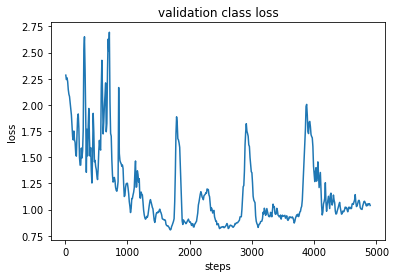

In [9]:
plt.title('validation class loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(steps, class_loss)

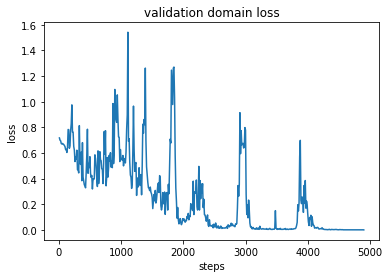

In [10]:
plt.title('validation domain loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(steps, domain_loss)

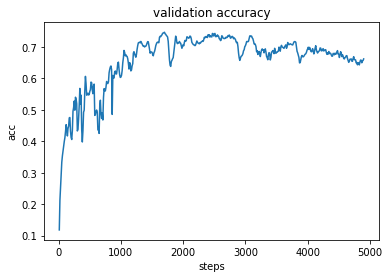

In [11]:
plt.title('validation accuracy')
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(steps, val_acc)